In [23]:
import numpy as np
import pandas as pd

np.random.seed(0)

n = 1000
p = 10

X = np.random.randn(n, p)

true_beta = np.zeros(p)
true_beta[:5] = [5, -3, 2, 0, 4]

noise = np.random.randn(n)
Y = X @ true_beta + noise

df = pd.DataFrame(X, columns=[f'X{i}' for i in range(p)])
df['Y'] = Y

In [24]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=900)

In [25]:
from itertools import combinations
from ISLP.models import ModelSpec as MS 
import statsmodels.api as sm

def get_best_subset(df: pd.DataFrame, target='Y', max_features=10):
    n_features = df.shape[1] - 1
    best_models = {}
    X_columns = df.columns.drop(target)
    Y = df[target]
    for k in range(1, max_features + 1):
        best_mse = np.inf
        best_combo = None
        for combo in combinations(range(n_features), k):
            combo = X_columns[list(combo)]
            design = MS(combo).fit_transform(df)
            results = sm.OLS(Y, design).fit()
            mse = ((results.fittedvalues - Y) ** 2).mean()
            if mse < best_mse:
                best_mse = mse
                best_combo = combo
        best_models[k] = (best_mse, best_combo)
    return best_models

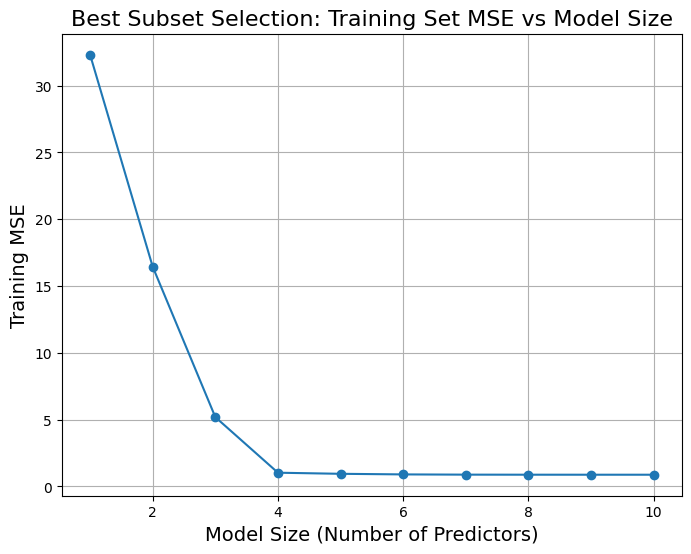

In [26]:

best_models = get_best_subset(df_train, 'Y', max_features=10)

import matplotlib.pyplot as plt

model_sizes = list(best_models.keys())
train_mses = [best_models[k][0] for k in model_sizes]

plt.figure(figsize=(8, 6))
plt.plot(model_sizes, train_mses, marker='o')
plt.xlabel("Model Size (Number of Predictors)", fontsize=14)
plt.ylabel("Training MSE", fontsize=14)
plt.title("Best Subset Selection: Training Set MSE vs Model Size", fontsize=16)
plt.grid(True)
plt.show()


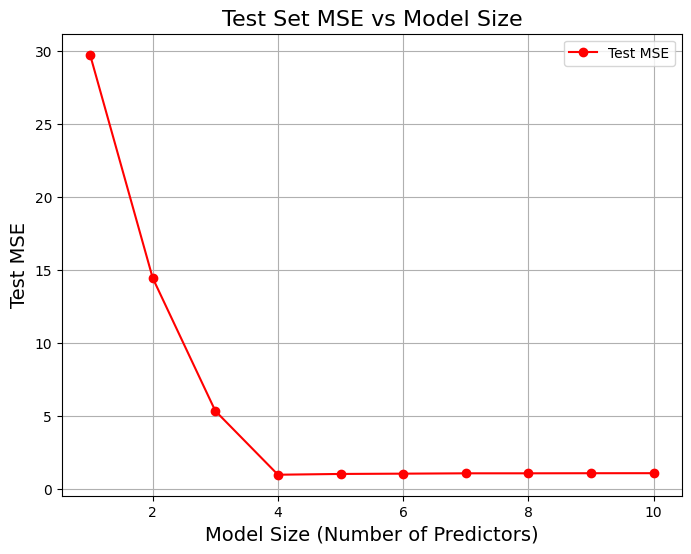

In [27]:
test_mses = []

for k in range(1, 11):
    _, best_combo = best_models[k]
    # Fit model on training data
    design_train = MS(best_combo).fit_transform(df_train)
    Y_train = df_train['Y']
    results = sm.OLS(Y_train, design_train).fit()
    
    # Predict on test data
    design_test = MS(best_combo).fit_transform(df_test)
    Y_test = df_test['Y']
    predictions = results.predict(design_test)
    mse = ((predictions - Y_test) ** 2).mean()
    test_mses.append(mse)

plt.figure(figsize=(8, 6))
plt.plot(model_sizes, test_mses, marker='o', label='Test MSE', color='red')
plt.xlabel("Model Size (Number of Predictors)", fontsize=14)
plt.ylabel("Test MSE", fontsize=14)
plt.title("Test Set MSE vs Model Size", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()


In [28]:
min_mse = min(test_mses)
best_size = model_sizes[np.argmin(test_mses)]
print(f"Minimum Test MSE: {min_mse:.4f} at model size {best_size}")

Minimum Test MSE: 0.9980 at model size 4


The model achieves its minimum test set MSE at size 4, which aligns with the point where the training MSE stabilizes, indicating that the first four predictors capture most of the signal in the data. Beyond this size, adding more variables offers diminishing returns and very slightly increases test error, suggesting mild overfitting. This confirms that a model of intermediate complexity (size 4) provides the best balance between bias and variance for this dataset.

In [29]:
best_models[4]

(np.float64(1.029293836796739),
 Index(['X0', 'X1', 'X2', 'X4'], dtype='object'))

In [30]:
_, best_combo = best_models[4]

design = MS(best_combo).fit_transform(df)
Y = df['Y']
results = sm.OLS(Y, design).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.334e+04
Date:                Tue, 05 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:36:25   Log-Likelihood:                -1414.5
No. Observations:                1000   AIC:                             2839.
Df Residuals:                     995   BIC:                             2863.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0578      0.032      1.829      0.068      -0.004       0.120
X0             4.9527      0.031    159.334      0.000       4.892       5.014
X1            -3.0432      0.032    -94.666      0.000      -3.106      -2.980
X2             2.0565      0.032     65.017      0.000       1.994       2.119
X4             4.0646      0.032    127.447      0.000       4.002       4.127
==============================================================================
Omnibus:                        1.816   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.793
Skew:                           0.104   Prob(JB):                        0.408
Kurtosis:                       2.995   Cond. No.                         1.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The estimated coefficients from the best subset model of size 4 align closely with the true data-generating process. The model correctly identifies and assigns non-zero weights to the features with true non-zero effects, capturing the correct signs and magnitudes of most coefficients, particularly for features 0, 1, 2, and 4. Features with true zero coefficients are appropriately excluded, suggesting that the subset selection procedure has effectively separated signal from noise. This indicates that the method has strong variable selection capability under this simulation setup, recovering the true sparsity pattern well.

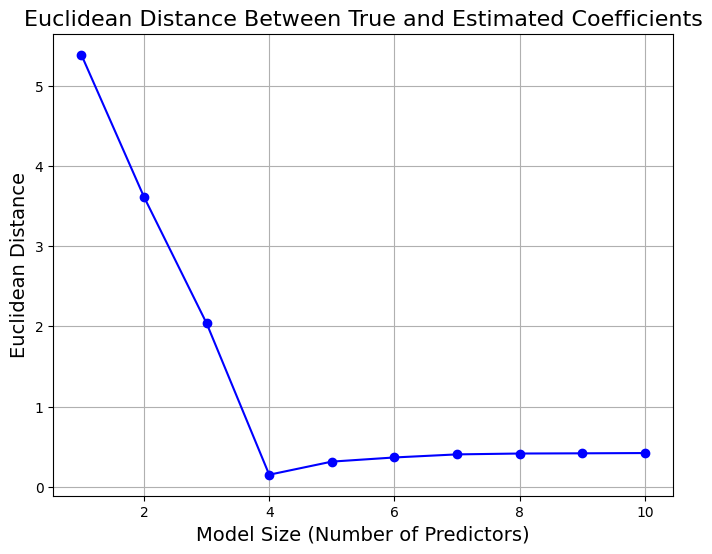

In [41]:
def compute_beta_distances(df, beta_true, best_models):
    distances = []
    for k in range(1, len(best_models) + 1):
        _, best_combo = best_models[k]
        design = MS(best_combo).fit_transform(df)
        Y = df['Y']
        results = sm.OLS(Y, design).fit()
        
        beta_hat = np.zeros_like(beta_true, dtype=float)
        feature_indices = [int(col[1:]) for col in best_combo]
        beta_hat[feature_indices] = results.params.values[1:]
        dist = np.sqrt(np.sum((beta_hat - beta_true) ** 2))
        distances.append(dist)
    return distances

beta_distances = compute_beta_distances(df_train, true_beta, best_models)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(beta_distances) + 1), beta_distances, marker='o', color='blue')
plt.xlabel("Model Size (Number of Predictors)", fontsize=14)
plt.ylabel("Euclidean Distance", fontsize=14)
plt.title("Euclidean Distance Between True and Estimated Coefficients", fontsize=16)
plt.grid(True)
plt.show()


The plot of the Euclidean distance between the true and estimated coefficients shows a clear pattern: the distance steadily decreases as model size increases up to 4 predictors, then begins to slightly increase and eventually stabilizes. This indicates that the most relevant predictors—those with non-zero coefficients in the true model—are captured within the first 4 predictors.